## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'coco-outdoor' 
TRANSFORM = 'wavelet-horizontal'
CHANNEL = 'red'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
red_horizontal_wavelet_outdoor_coco.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/coco/outdoor/wavelet/horizontal/red'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 2446,
 3: 9784,
 4: 39136,
 5: 156544,
 6: 626176,
 7: 2504704,
 8: 10018816,
 9: 40075264}

Running 12760 CDFs


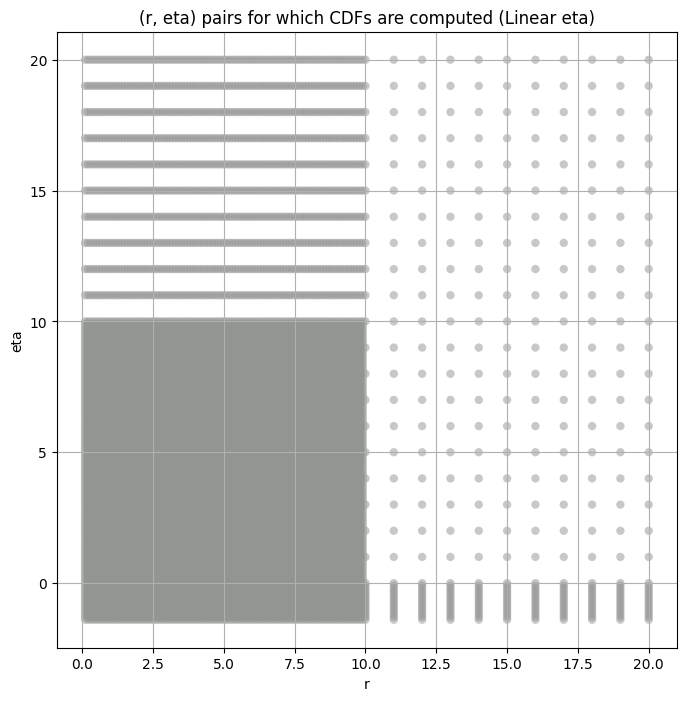

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df['total_samples'] = master_df['total_samples'].astype(int)
    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      7638.174300  7124.338000  8164.031200  -0.282708   -0.434939   
3      1626.871300  1559.126000  1696.707300   0.652731    0.513061   
4       341.027560   323.160430   359.463470   2.263896    1.864998   
5        65.812890    61.691994    70.081420   4.177919    3.517911   
6        12.935615    11.939695    14.019106   7.678164    5.766460   
7         2.520173     2.289406     2.793002  12.723302    8.106244   
8         0.541199     0.483270     0.626779  22.243805   10.200109   
9         0.143161     0.127398     0.167005  24.571327   11.068905   

       kurt_upper  total_samples  
layer                             
2       -0.114432           2446  
3        0.798774           9784  
4        2.751698          39136  
5        4.988661         156544  
6       12.299148         626176  
7       33.117836        2504704  
8       93.252760       10018816  
9       97.773170       40075264

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                               
2      7638.174300    7638.174316     6835.617188     6253.932617   
3      1626.871300    1626.871338     1546.126953     1482.777832   
4       341.027560     341.027557      331.391235      324.543579   
5        65.812890      65.812889       64.639061       63.774986   
6        12.935615      12.935615       12.546919       12.311246   
7         2.520173       2.520174        2.418866        2.361549   
8         0.541199       0.541199        0.513010        0.498928   
9         0.143161       0.143161        0.135190        0.131228   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2         5736.568848      5281.297363      4550.144531      3971.309814   
3         1428.800537      1379.897827      1292.285278      1214.854858   
4          318.762329       313.493744       303.959656       295.482758   
5           63.015041        62.325871        61.064606        59.921043   
6           12.111331        11.932793        11.616343        11.336363   
7            2.313668         2.271217         2.196674         2.131399   
8            0.487079         0.476577         0.458278         0.442432   
9            0.127935         0.125037         0.120007         0.115670   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2          3450.937256      3001.316895      2616.318359      1690.341309  
3          1145.687622      1083.598022      1027.279663       883.909241  
4           287.667816       280.426819       273.613464       255.754883  
5            58.867619        57.886810        56.970551        54.502529  
6            11.081654        10.847749        10.630193        10.049282  
7             2.072844         2.019422         1.970211         1.841061  
8             0.428308         0.415509         0.403784         0.373450  
9             0.111818         0.108338         0.105158         0.096952

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.04033898134164515 7638.1743


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.05268181669433625 6835.617


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.06279233141974949 6253.9326


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.0727779680091799 5736.569


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.08247727216935596 5281.2974


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.10022207403822381 4550.1445


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.11661556654558514 3971.3098


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.13358100751808133 3450.9373


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.1503192425247698 3001.317


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.1664750127292265 2616.3184


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.21356843545921267 1690.3413
Number of samples: 2446, Without approximation : 2446


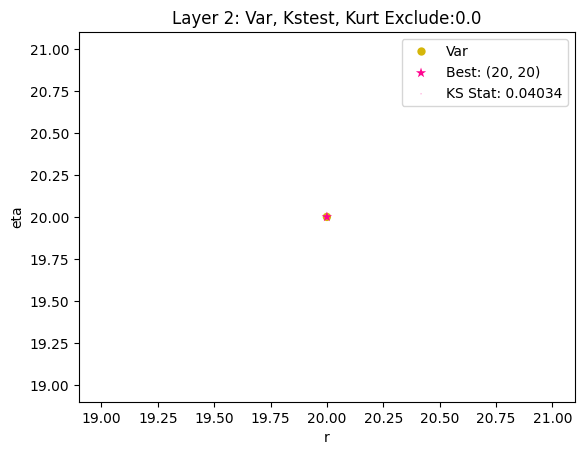

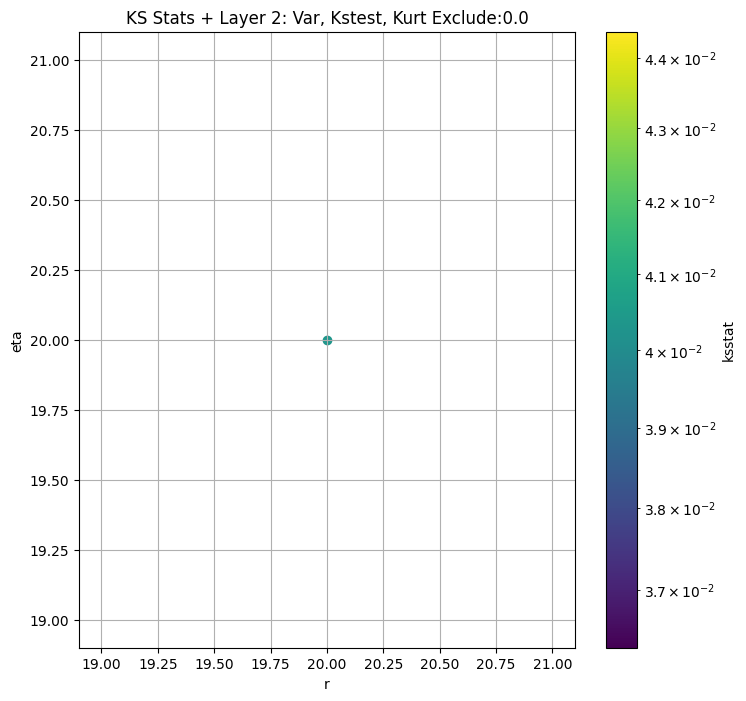

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.02676104483091779 1626.8713


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.027189422223070248 1546.127


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.027737210193485462 1482.7778


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.02791785845572403 1428.8005


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.028247370208127176 1379.8978


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.02914140289552003 1292.2853


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.033510681358780325 1214.8549


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.03844174714526272 1145.6876


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.043418724822677945 1083.598


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.048033673449623726 1027.2797


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.062222740302521284 883.90924
Number of samples: 9784, Without approximation : 9784


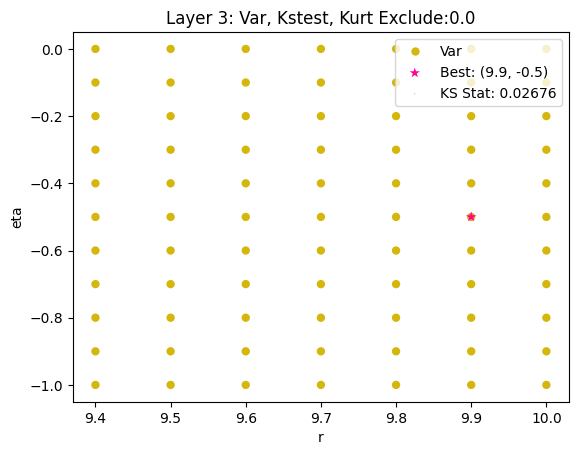

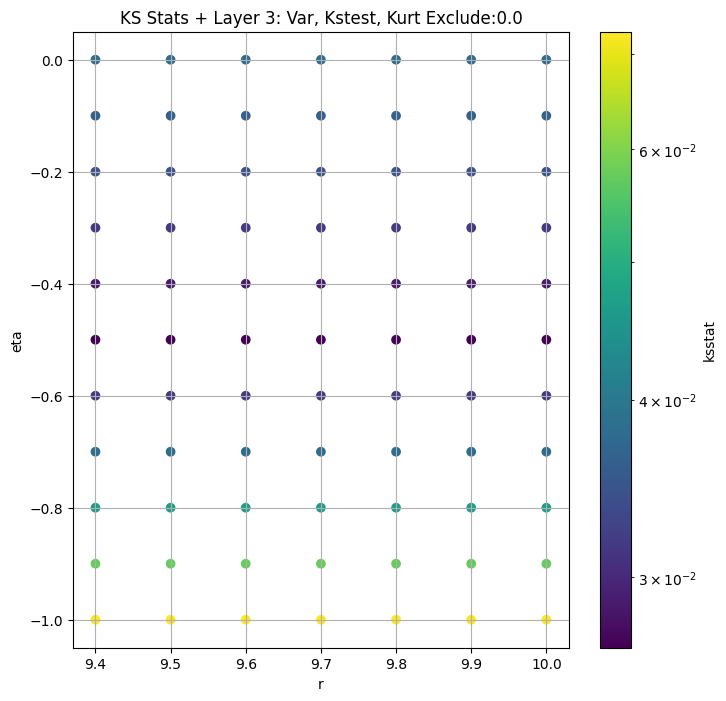

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.017805504433858754 341.02756


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.018081353085521723 331.39124


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.018118683510192968 324.54358


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.018150725581715488 318.76233


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.01817242890224008 313.49374


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.018188198993804916 303.95966


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.018177150892014604 295.48276


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.01819449159757519 287.66782


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.01824025361674264 280.42682


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.01824390807107784 273.61346


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.02019076962992794 255.75488
Number of samples: 39136, Without approximation : 39136


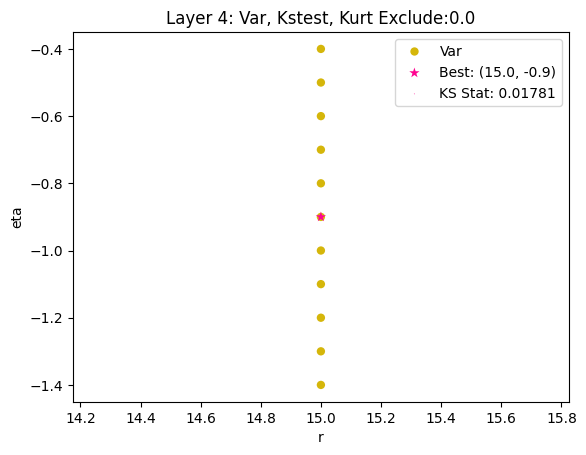

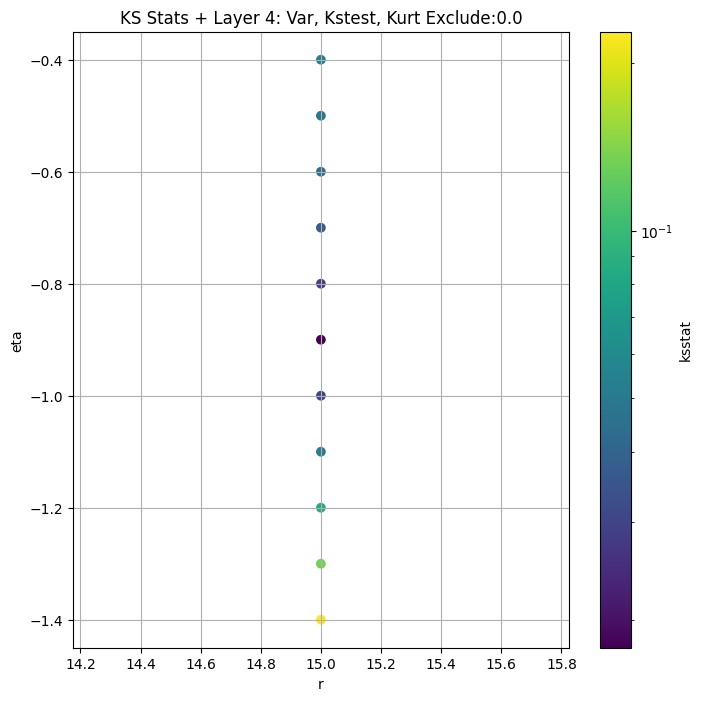

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.01625664219019579 65.81289


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.016240646602579345 64.63906


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.016228594982056477 63.774986


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.016217794509905403 63.01504


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.016208463421872765 62.32587


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.016196353799177998 61.064606


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.016292471632831207 59.921043


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.016276467896427393 58.86762


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.016265105479268238 57.88681


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.016255719998863938 56.97055


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.016229285988810682 54.50253
Number of samples: 100000, Without approximation : 156544


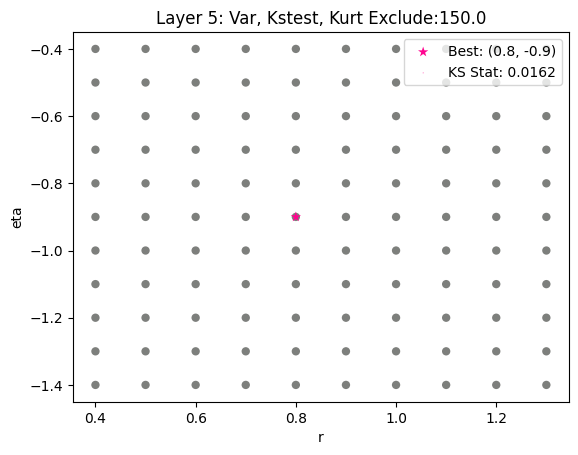

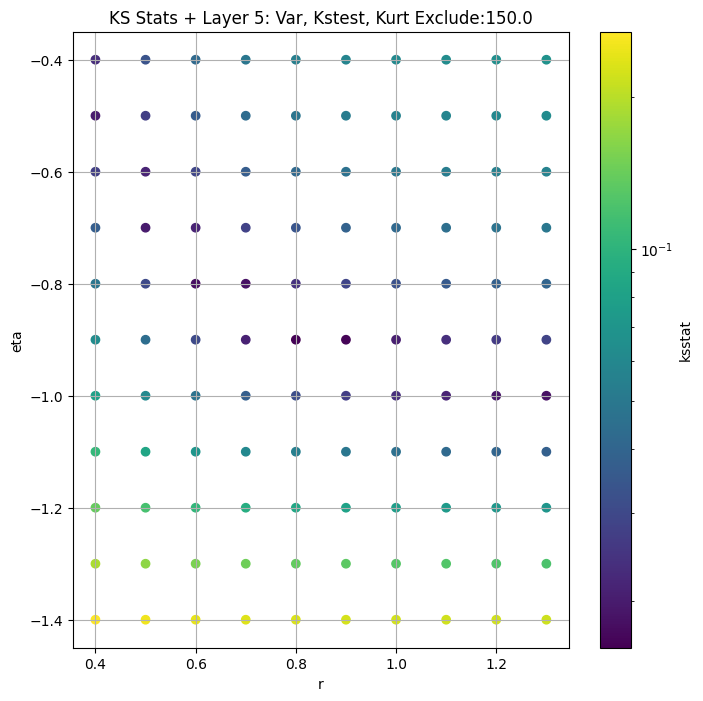

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.018391540428672193 12.935615


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.018283459477581976 12.546919


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.018218469594186715 12.311246


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.018162998271594066 12.111331


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.01811234259583583 11.932793


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.018019851187287494 11.616343


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.018775327324221325 11.336363


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.01869619934680461 11.081654


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.01862122382592285 10.847749


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.018549401160298074 10.630193


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.018348287451010026 10.049282
Number of samples: 100000, Without approximation : 626176


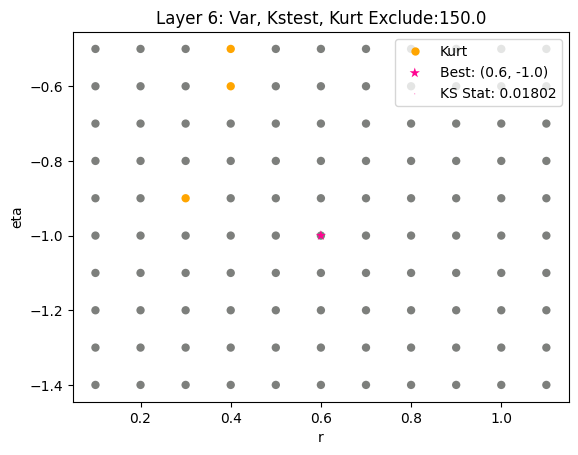

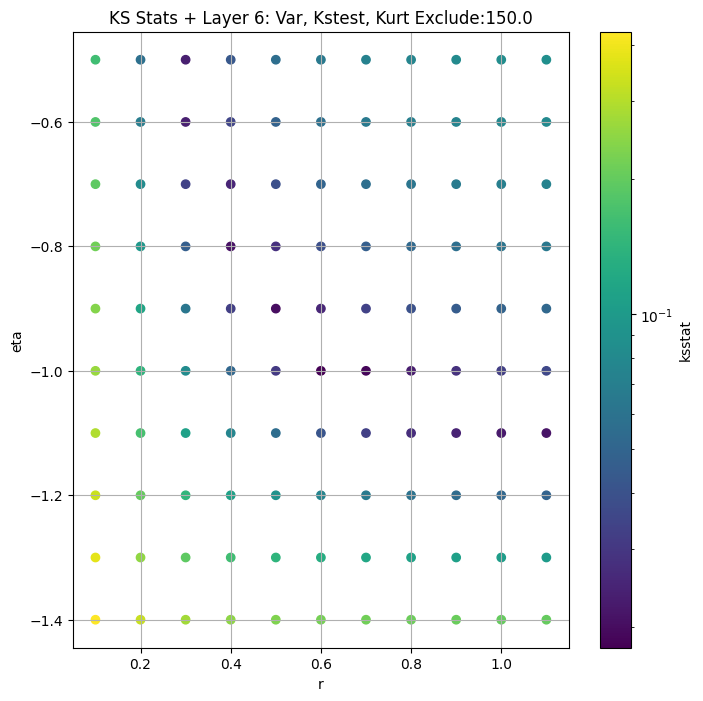

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.019797922328420037 2.5201735


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.019473033364867942 2.418866


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.019283104629284564 2.3615491


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.019121045353555022 2.3136678


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.0189739247406156 2.271217


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.019303826276711344 2.1966743


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.019913512281942103 2.1313994


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.019694099106257246 2.072844


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.01948653318008209 2.0194216


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.019291505458715497 1.9702106


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.019685143376842906 1.8410606
Number of samples: 100000, Without approximation : 2504704


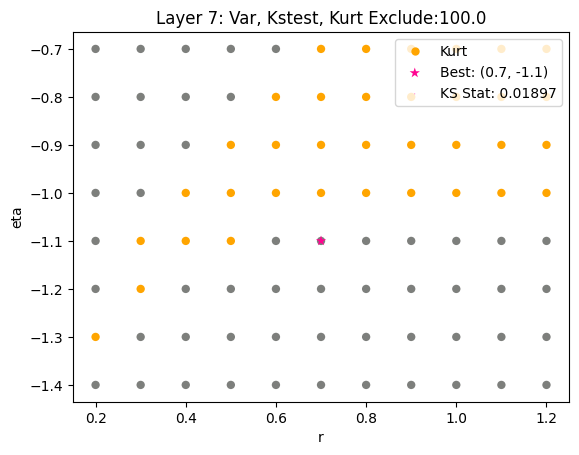

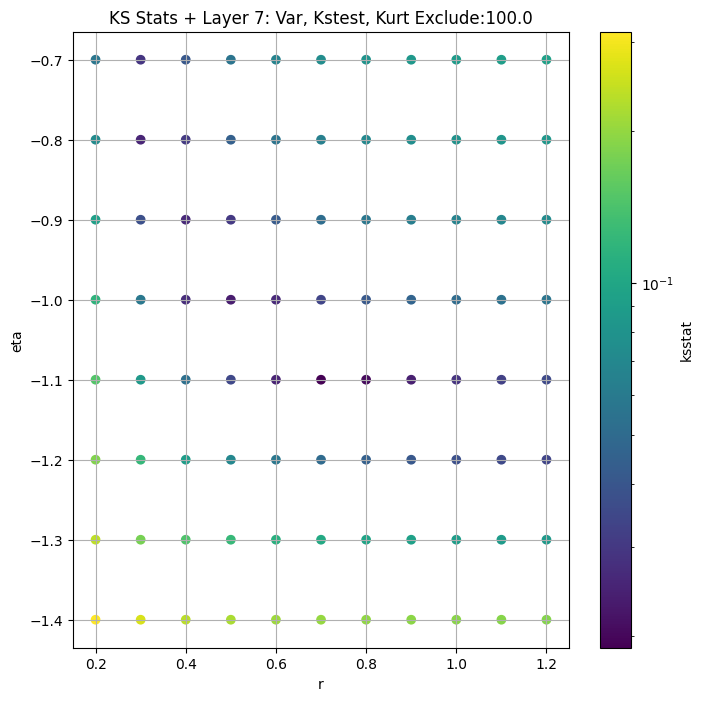

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.00803870932552686 0.5411992


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.010248575115797687 0.5130096


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.011435673662405388 0.49892753


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.011399265330224673 0.48707914


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.010110164357193363 0.4765772


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.011218582371403163 0.458278


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.012364028316259712 0.4424321


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.013455635048649328 0.42830786


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.01226400408881817 0.4155093


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.010634361578173157 0.4037838


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.01073556288843558 0.37345043
Number of samples: 100000, Without approximation : 10018816


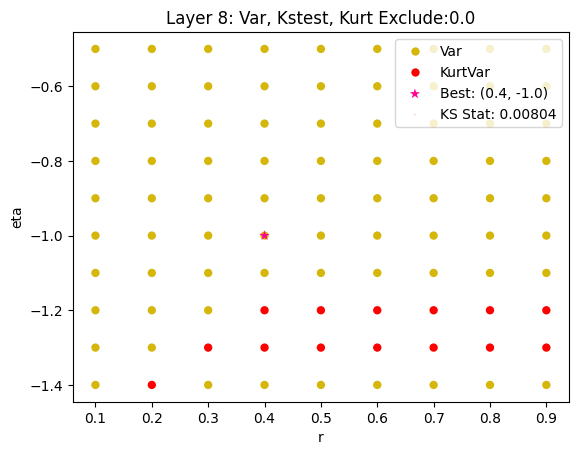

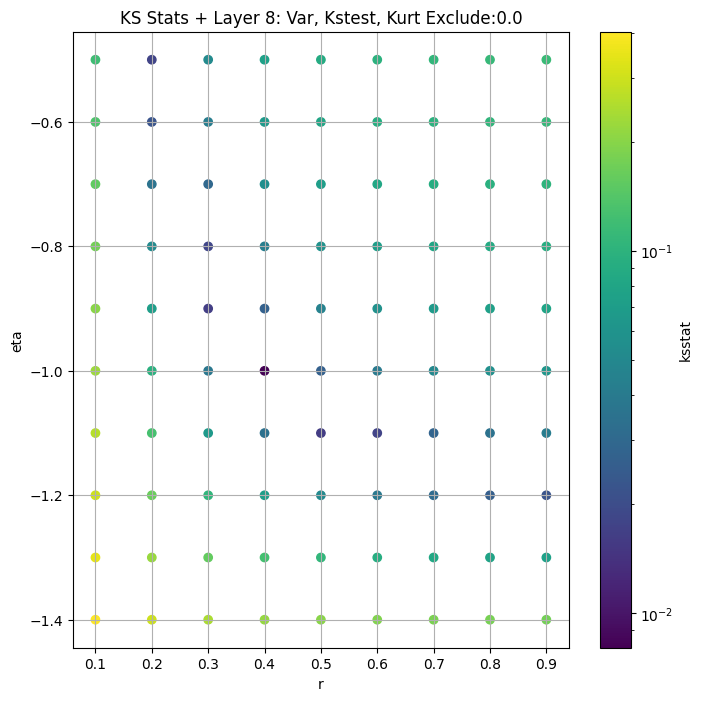

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.012848050161488156 0.14316116


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.010605879064646162 0.13518955


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.010840092956646452 0.13122766


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.011045971958196676 0.12793468


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.011238139154506777 0.1250367


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.011597744610588823 0.120006934


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.011199392053961421 0.11566959


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.010891664067758544 0.111818396


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.012504883884894014 0.10833784


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.011771321410815161 0.10515758


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.010850213184940151 0.096951984
Number of samples: 100000, Without approximation : 40075264


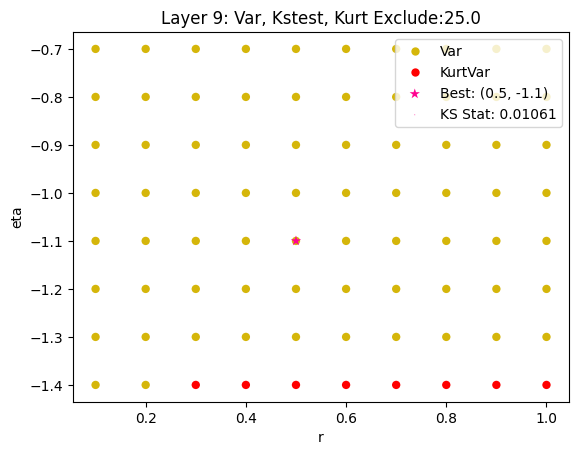

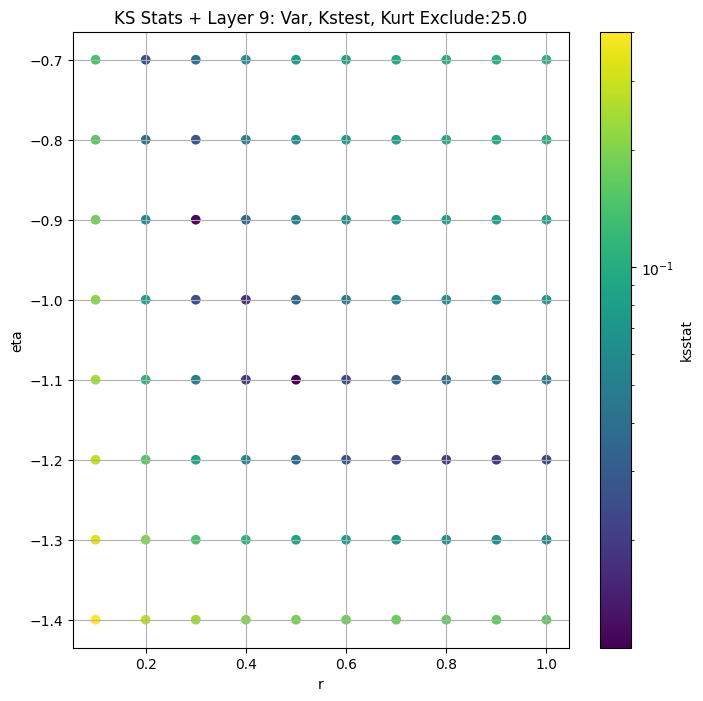

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      7638.174300  7124.338000  8164.031200  -0.282708   -0.434939   
3      1626.871300  1559.126000  1696.707300   0.652731    0.513061   
4       341.027560   323.160430   359.463470   2.263896    1.864998   
5        65.812890    61.691994    70.081420   4.177919    3.517911   
6        12.935615    11.939695    14.019106   7.678164    5.766460   
7         2.520173     2.289406     2.793002  12.723302    8.106244   
8         0.541199     0.483270     0.626779  22.243805   10.200109   
9         0.143161     0.127398     0.167005  24.571327   11.068905   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       -0.114432           2446             0.040339       20.0         20.0   
3        0.798774           9784             0.026761        9.9         -0.5   
4        2.751698          39136             0.017806       15.0         -0.9   
5        4.988661         156544             0.016196        0.8         -0.9   
6       12.299148         626176             0.018020        0.6         -1.0   
7       33.117836        2504704             0.018974        0.7         -1.1   
8       93.252760       10018816             0.008039        0.4         -1.0   
9       97.773170       40075264             0.010606        0.5         -1.1   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2        7801.812320                     0.0         7638.174300   
3        3371.850170                     0.0         1626.871300   
4         937.916198                     0.0          341.027560   
5          74.829588                   150.0           61.064606   
6           9.863822                   150.0           11.616343   
7           3.539876                   100.0            2.271217   
8           0.110908                     0.0            0.541199   
9           0.093882                    25.0            0.135190   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.027391  
3                     0.013713  
4                     0.006861  
5                     0.003431  
6                     0.001716  
7                     0.000858  
8                     0.000429  
9                     0.000215

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.08247727216935596, var: 5281.29736328125


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.0727779680091799, var: 5736.56884765625


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.06279233141974949, var: 6253.9326171875


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.05268181669433625, var: 6835.6171875


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.04033898134164515, var: 7638.17431640625
Number of samples: 2446, Without approximation : 2446


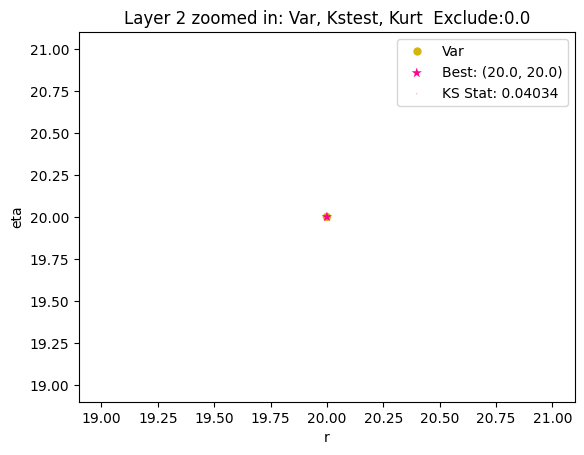

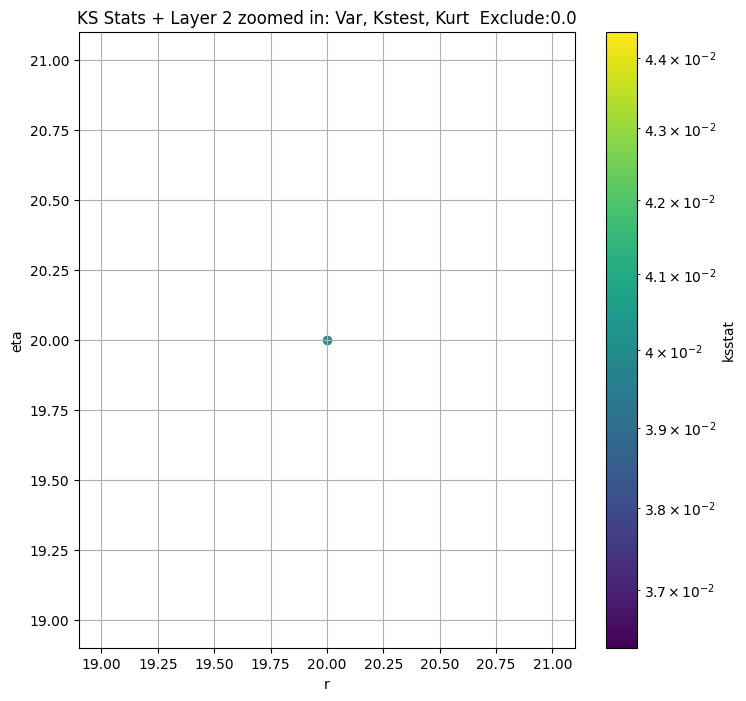

Layer 3


  0%|          | 0/54 [00:00<?, ?it/s]

Finding Minimum after computing 54 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.02855384770419922, var: 1379.8978271484375


  0%|          | 0/54 [00:00<?, ?it/s]

Finding Minimum after computing 54 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.028459641976184114, var: 1428.800537109375


  0%|          | 0/54 [00:00<?, ?it/s]

Finding Minimum after computing 54 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.028272546046988534, var: 1482.77783203125


  0%|          | 0/54 [00:00<?, ?it/s]

Finding Minimum after computing 54 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.02759927022649966, var: 1546.126953125


  0%|          | 0/54 [00:00<?, ?it/s]

Finding Minimum after computing 54 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.02676104483091779, var: 1626.871337890625
Number of samples: 9784, Without approximation : 9784


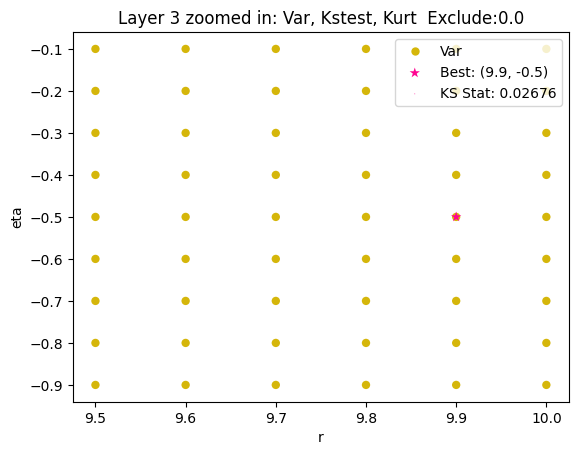

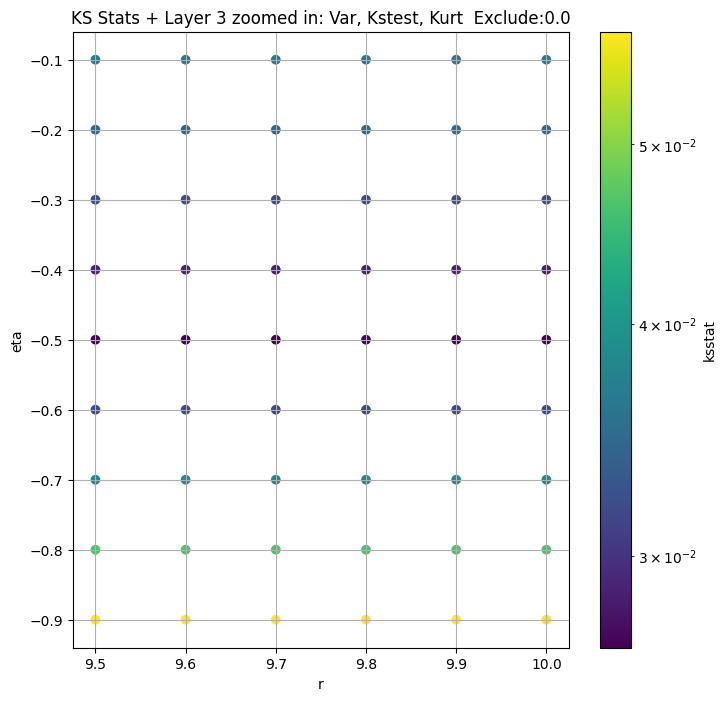

Layer 4


  0%|          | 0/10 [00:00<?, ?it/s]

Finding Minimum after computing 10 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.019150193995581377, var: 313.4937438964844


  0%|          | 0/10 [00:00<?, ?it/s]

Finding Minimum after computing 10 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.01888030268722396, var: 318.7623291015625


  0%|          | 0/10 [00:00<?, ?it/s]

Finding Minimum after computing 10 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.018591288362814207, var: 324.5435791015625


  0%|          | 0/10 [00:00<?, ?it/s]

Finding Minimum after computing 10 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.018258196945933558, var: 331.3912353515625


  0%|          | 0/10 [00:00<?, ?it/s]

Finding Minimum after computing 10 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.017805504433858754, var: 341.0275573730469
Number of samples: 39136, Without approximation : 39136


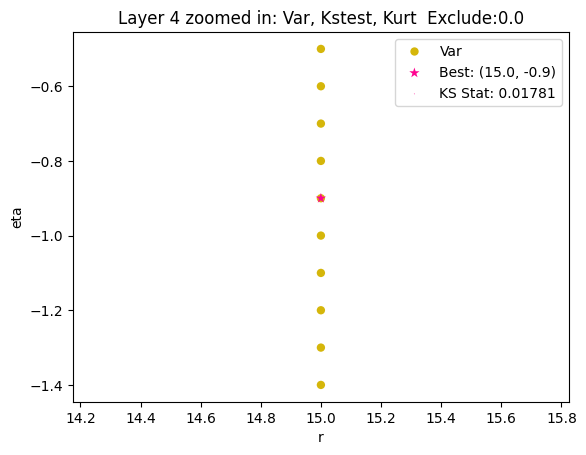

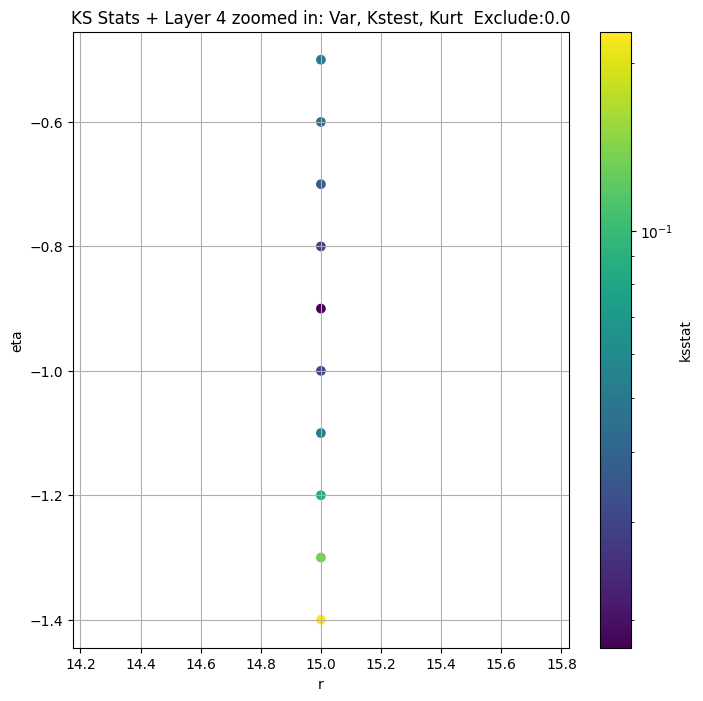

Layer 5


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 150.0 + 100 = 250, ksstat: 0.01608397689024993, var: 58.867618560791016


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 150.0 + 75 = 225, ksstat: 0.016089859165772546, var: 59.38511657714844


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 150.0 + 50 = 200, ksstat: 0.016119688072063654, var: 59.921043395996094


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 150.0 + 25 = 175, ksstat: 0.016125757283731723, var: 60.47905731201172


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 150.0 + 0 = 150, ksstat: 0.016069083063568246, var: 61.064605712890625


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 150.0 + -25 = 125, ksstat: 0.01607267673546975, var: 61.677494049072266


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 150.0 + -50 = 100, ksstat: 0.016079758860464588, var: 62.325870513916016


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 150.0 + -75 = 75, ksstat: 0.01610121365167133, var: 63.01504135131836


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 150.0 + -100 = 50, ksstat: 0.01610741263908777, var: 63.774986267089844
Number of samples: 100000, Without approximation : 156544


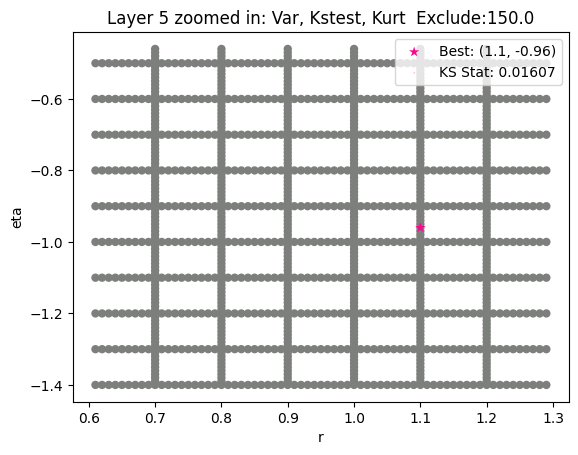

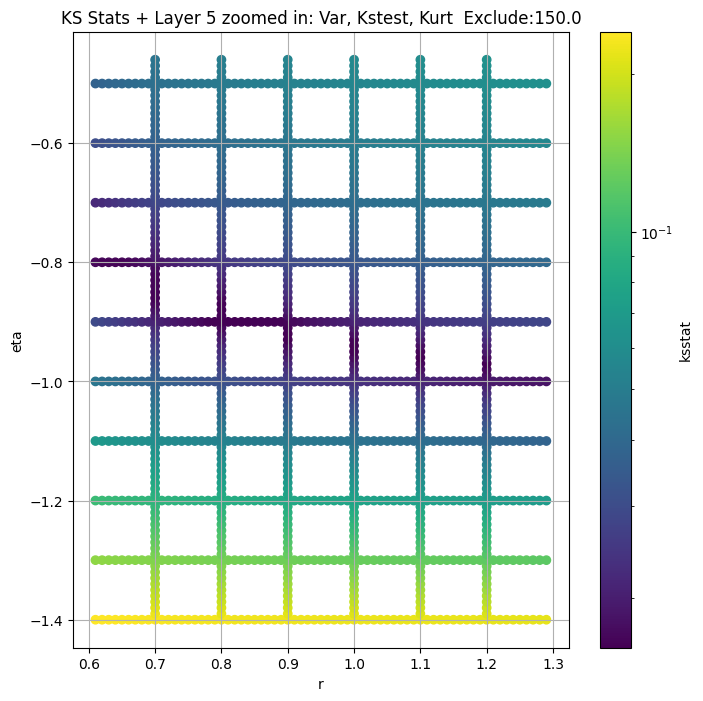

Layer 6


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 150.0 + 100 = 250, ksstat: 0.017606046986307633, var: 11.081653594970703


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 150.0 + 75 = 225, ksstat: 0.017643706701236606, var: 11.206256866455078


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 150.0 + 50 = 200, ksstat: 0.017683787236545956, var: 11.336362838745117


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 150.0 + 25 = 175, ksstat: 0.017725582977322296, var: 11.472813606262207


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 150.0 + 0 = 150, ksstat: 0.01777795169629426, var: 11.616342544555664


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 150.0 + -25 = 125, ksstat: 0.01770494868152761, var: 11.769095420837402


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 150.0 + -50 = 100, ksstat: 0.017536751869115408, var: 11.932792663574219


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 150.0 + -75 = 75, ksstat: 0.01771183903276674, var: 12.11133098602295


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 150.0 + -100 = 50, ksstat: 0.017509364743478972, var: 12.311245918273926
Number of samples: 100000, Without approximation : 626176


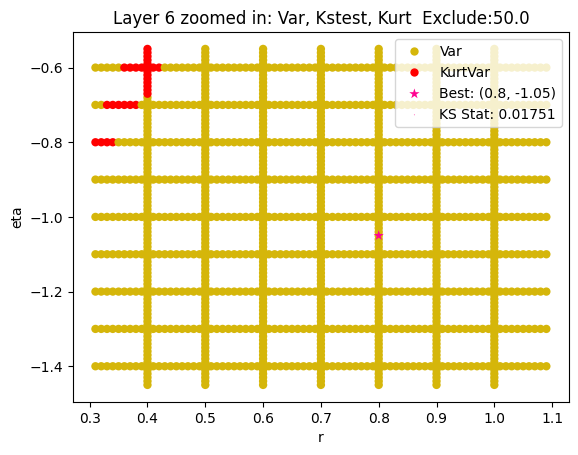

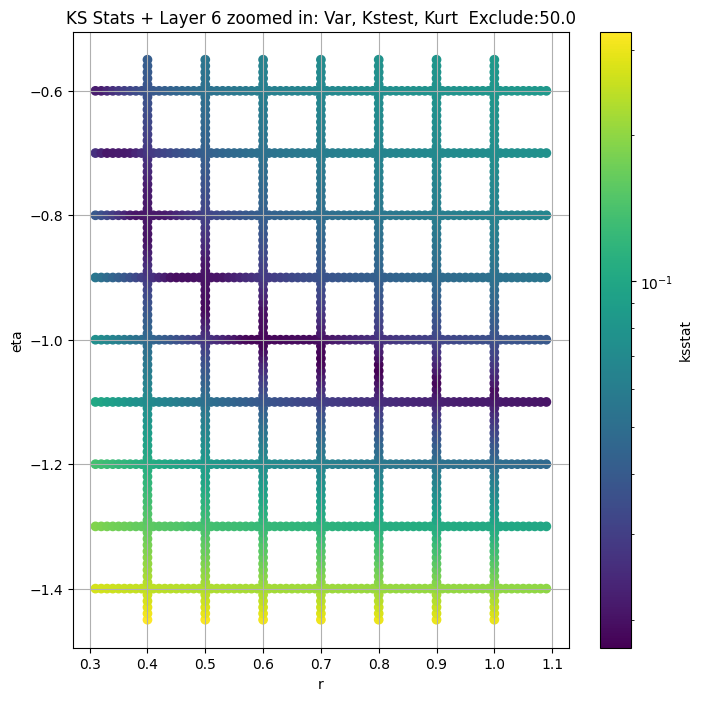

Layer 7


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 100.0 + 100 = 200, ksstat: 0.01810241167127541, var: 2.131399393081665


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 100.0 + 75 = 175, ksstat: 0.01845738489836707, var: 2.163067579269409


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 100.0 + 50 = 150, ksstat: 0.01881170585394354, var: 2.196674346923828


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 100.0 + 25 = 125, ksstat: 0.018405312692852283, var: 2.2325222492218018


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 100.0 + 0 = 100, ksstat: 0.017945224733378895, var: 2.271217107772827


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 100.0 + -25 = 75, ksstat: 0.017909227954557905, var: 2.3136677742004395


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 100.0 + -50 = 50, ksstat: 0.018292783021034653, var: 2.361549139022827


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 100.0 + -75 = 25, ksstat: 0.018482909025397953, var: 2.418865919113159


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 100.0 + -100 = 0, ksstat: 0.018563506170346078, var: 2.5201735496520996
Number of samples: 100000, Without approximation : 2504704


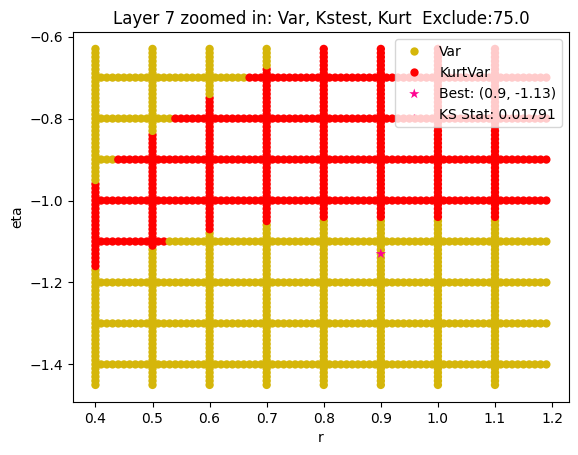

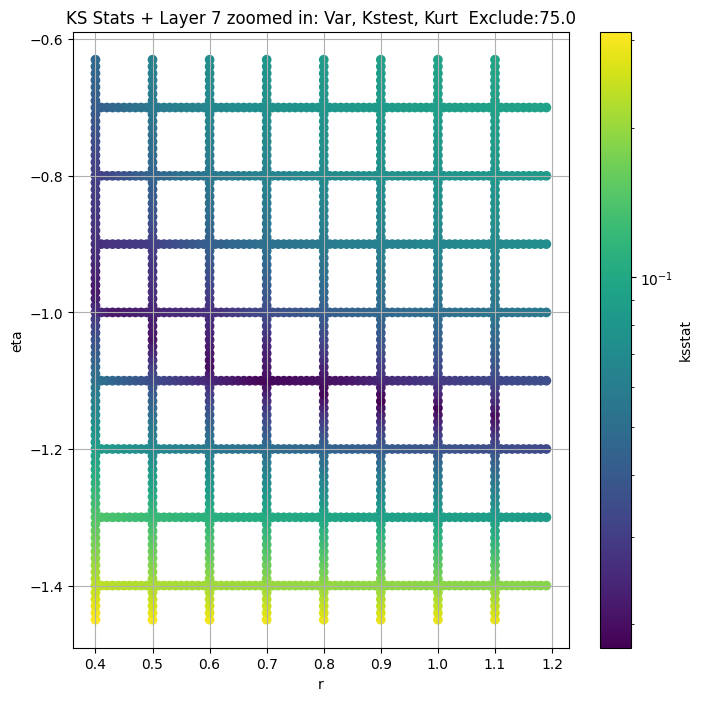

Layer 8


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 8, 0.0 + 100 = 100, ksstat: 0.008292031671158051, var: 0.47657719254493713


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 8, 0.0 + 75 = 75, ksstat: 0.008371284290741188, var: 0.4870791435241699


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 8, 0.0 + 50 = 50, ksstat: 0.008647790026738156, var: 0.4989275336265564


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 8, 0.0 + 25 = 25, ksstat: 0.008182615702489016, var: 0.5130096077919006


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 8, 0.0 + 0 = 0, ksstat: 0.00803870932552686, var: 0.5411992073059082
Number of samples: 100000, Without approximation : 10018816


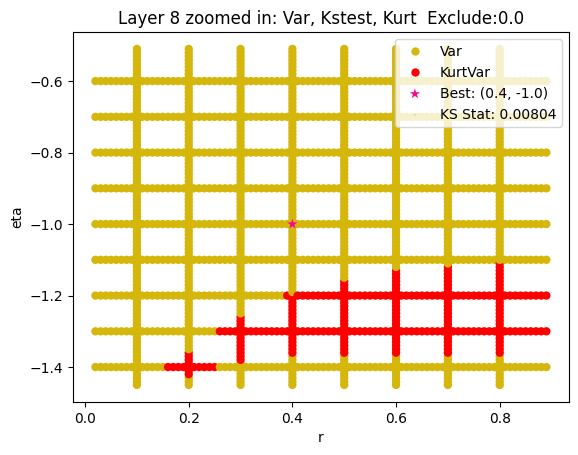

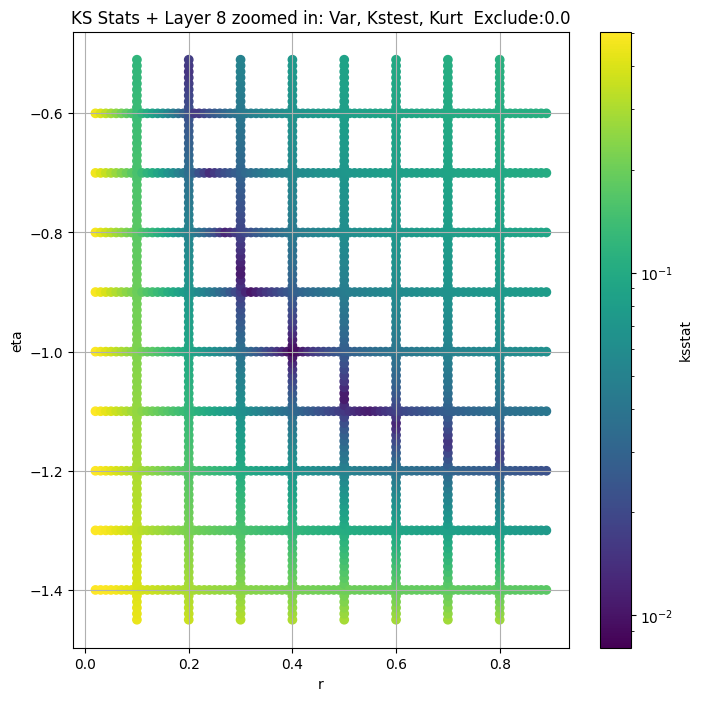

Layer 9


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 9, 25.0 + 100 = 125, ksstat: 0.00863079522063126, var: 0.1224164217710495


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 9, 25.0 + 75 = 100, ksstat: 0.00829981117513301, var: 0.12503670156002045


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 9, 25.0 + 50 = 75, ksstat: 0.00835515730558778, var: 0.12793467938899994


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 9, 25.0 + 25 = 50, ksstat: 0.008400382341143486, var: 0.13122765719890594


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 9, 25.0 + 0 = 25, ksstat: 0.008300297545940916, var: 0.13518954813480377


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 9, 25.0 + -25 = 0, ksstat: 0.00797369091101946, var: 0.14316116273403168
Number of samples: 100000, Without approximation : 40075264


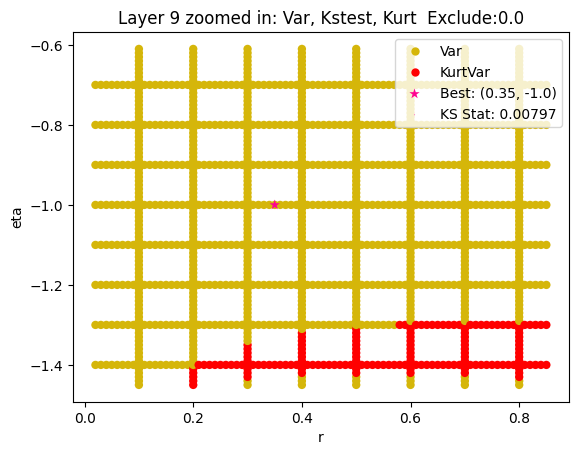

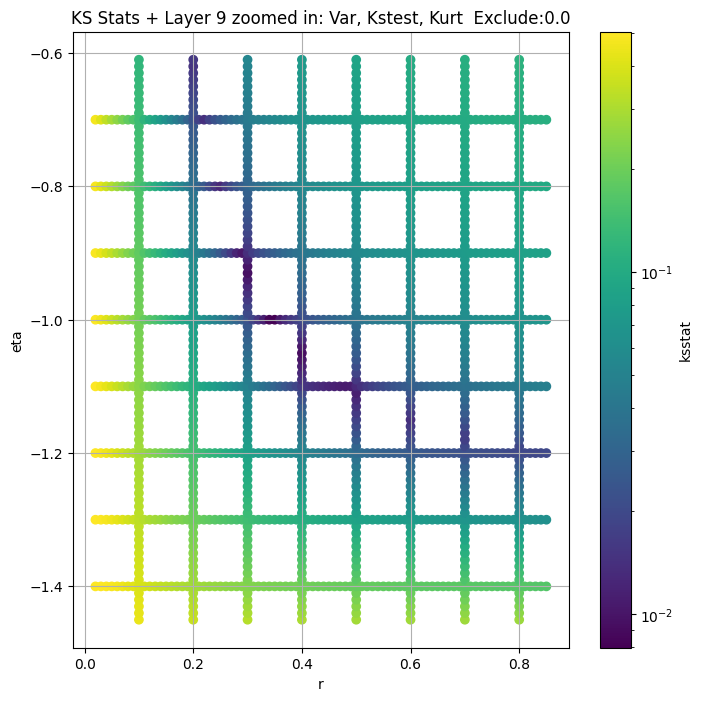

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      7638.174300  7124.338000  8164.031200  -0.282708   -0.434939   
3      1626.871300  1559.126000  1696.707300   0.652731    0.513061   
4       341.027560   323.160430   359.463470   2.263896    1.864998   
5        65.812890    61.691994    70.081420   4.177919    3.517911   
6        12.935615    11.939695    14.019106   7.678164    5.766460   
7         2.520173     2.289406     2.793002  12.723302    8.106244   
8         0.541199     0.483270     0.626779  22.243805   10.200109   
9         0.143161     0.127398     0.167005  24.571327   11.068905   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       -0.114432           2446             0.040339       20.0         20.0   
3        0.798774           9784             0.026761        9.9         -0.5   
4        2.751698          39136             0.017806       15.0         -0.9   
5        4.988661         156544             0.016196        0.8         -0.9   
6       12.299148         626176             0.018020        0.6         -1.0   
7       33.117836        2504704             0.018974        0.7         -1.1   
8       93.252760       10018816             0.008039        0.4         -1.0   
9       97.773170       40075264             0.010606        0.5         -1.1   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2        7801.812320                     0.0         7638.174300   
3        3371.850170                     0.0         1626.871300   
4         937.916198                     0.0          341.027560   
5          74.829588                   150.0           61.064606   
6           9.863822                   150.0           12.311246   
7           3.539876                   100.0            2.313668   
8           0.110908                     0.0            0.541199   
9           0.093882                    25.0            0.143161   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.027391          0.040339   20.00     20.00   
3                     0.013713          0.026761    9.90     -0.50   
4                     0.006861          0.017806   15.00     -0.90   
5                     0.003431          0.016069    1.10     -0.96   
6                     0.001716          0.017509    0.80     -1.05   
7                     0.000858          0.017909    0.90     -1.13   
8                     0.000429          0.008039    0.40     -1.00   
9                     0.000215          0.007974    0.35     -1.00   

        best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                 
2      7801.812320                  0.0         1158  
3      3371.850170                  0.0         2446  
4       937.916198                  0.0         5872  
5       124.209097                150.0         7338  
6        20.834967                 50.0         6190  
7         5.625084                 75.0         5503  
8         0.110908                  0.0        29352  
9         0.014601                  0.0        29352

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

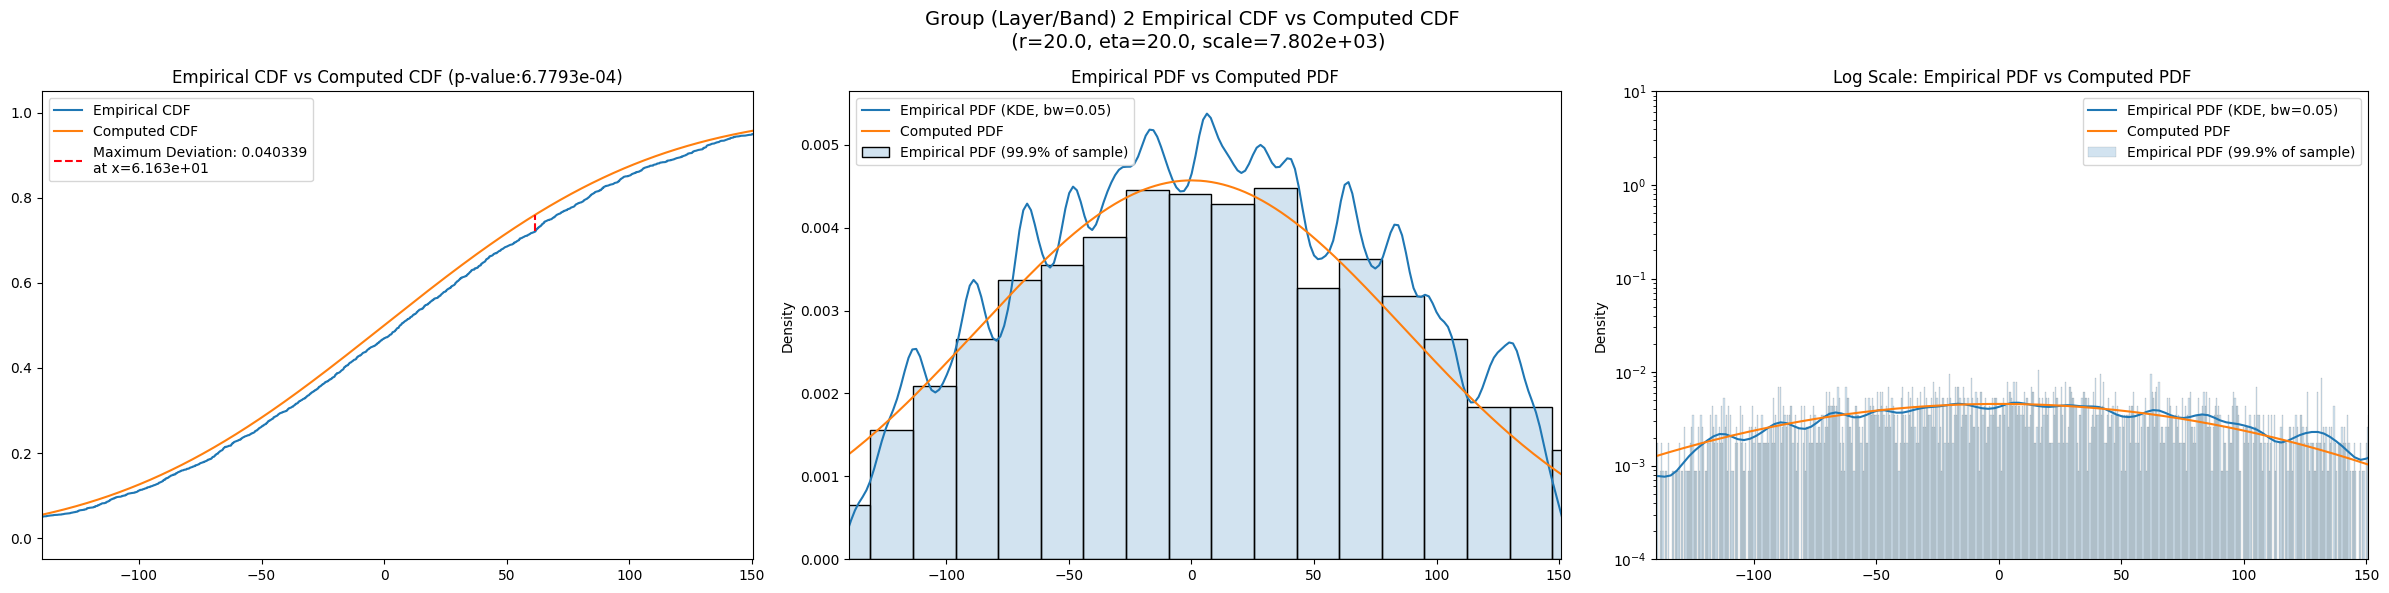

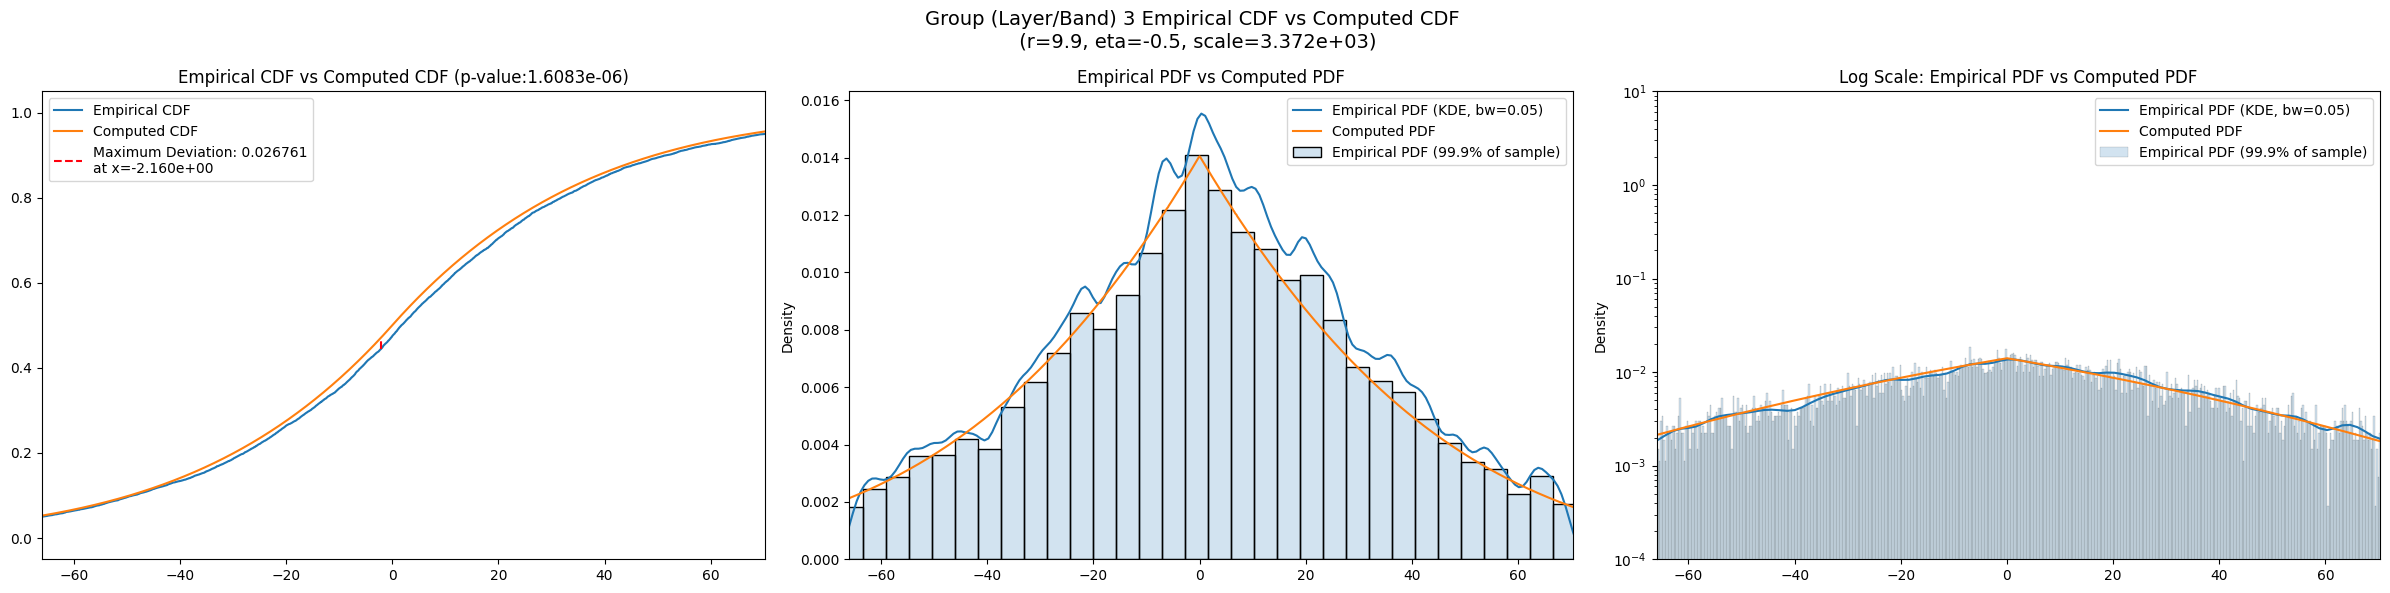

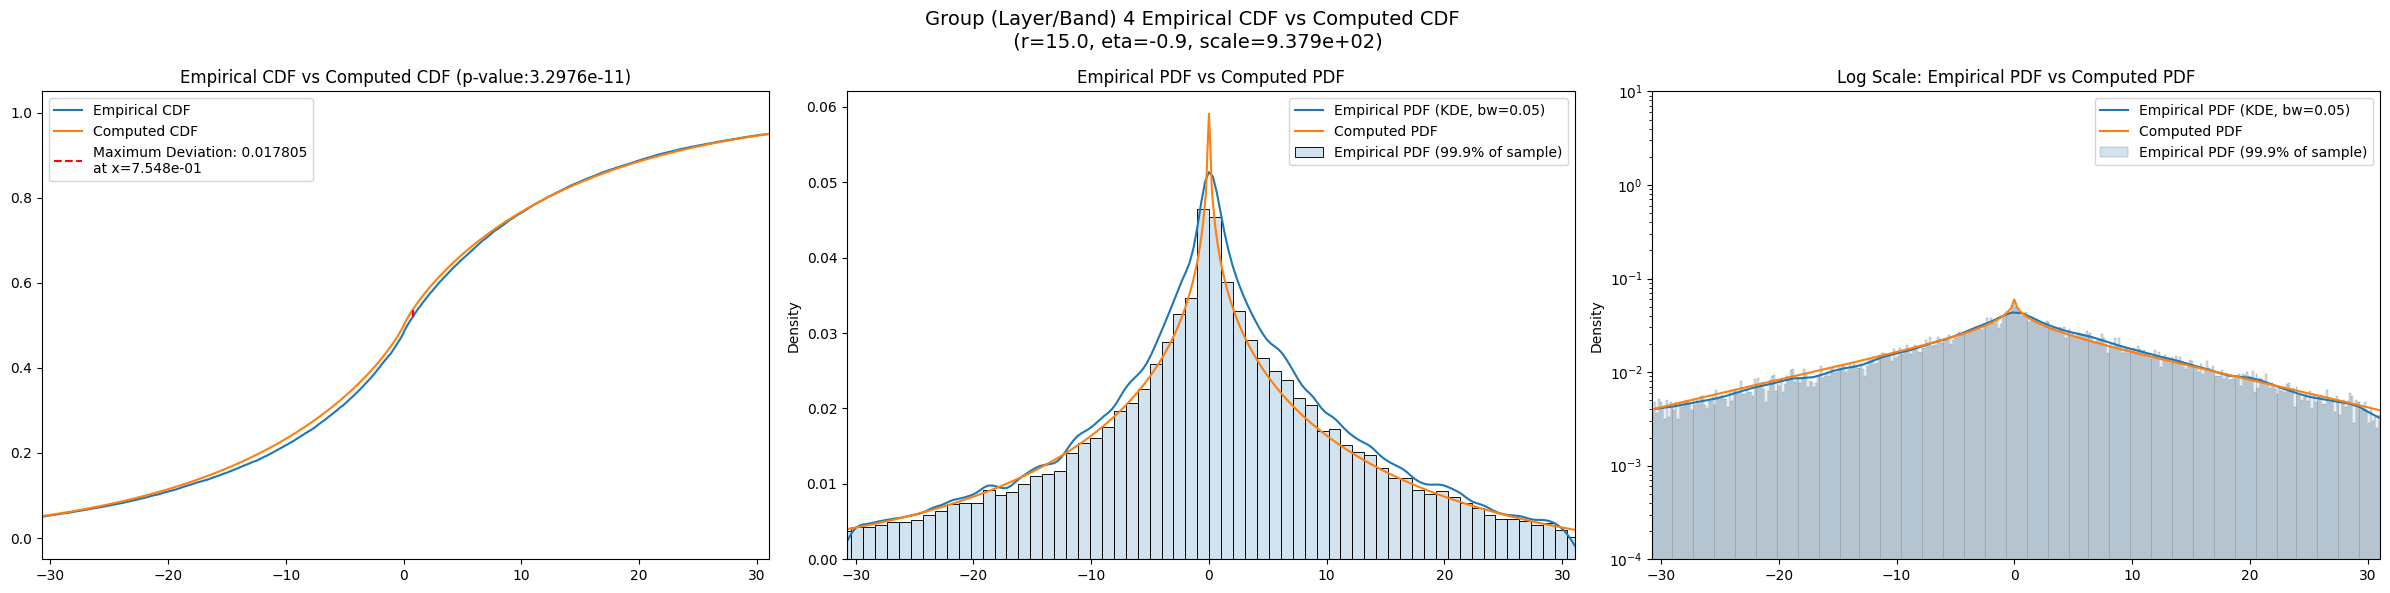

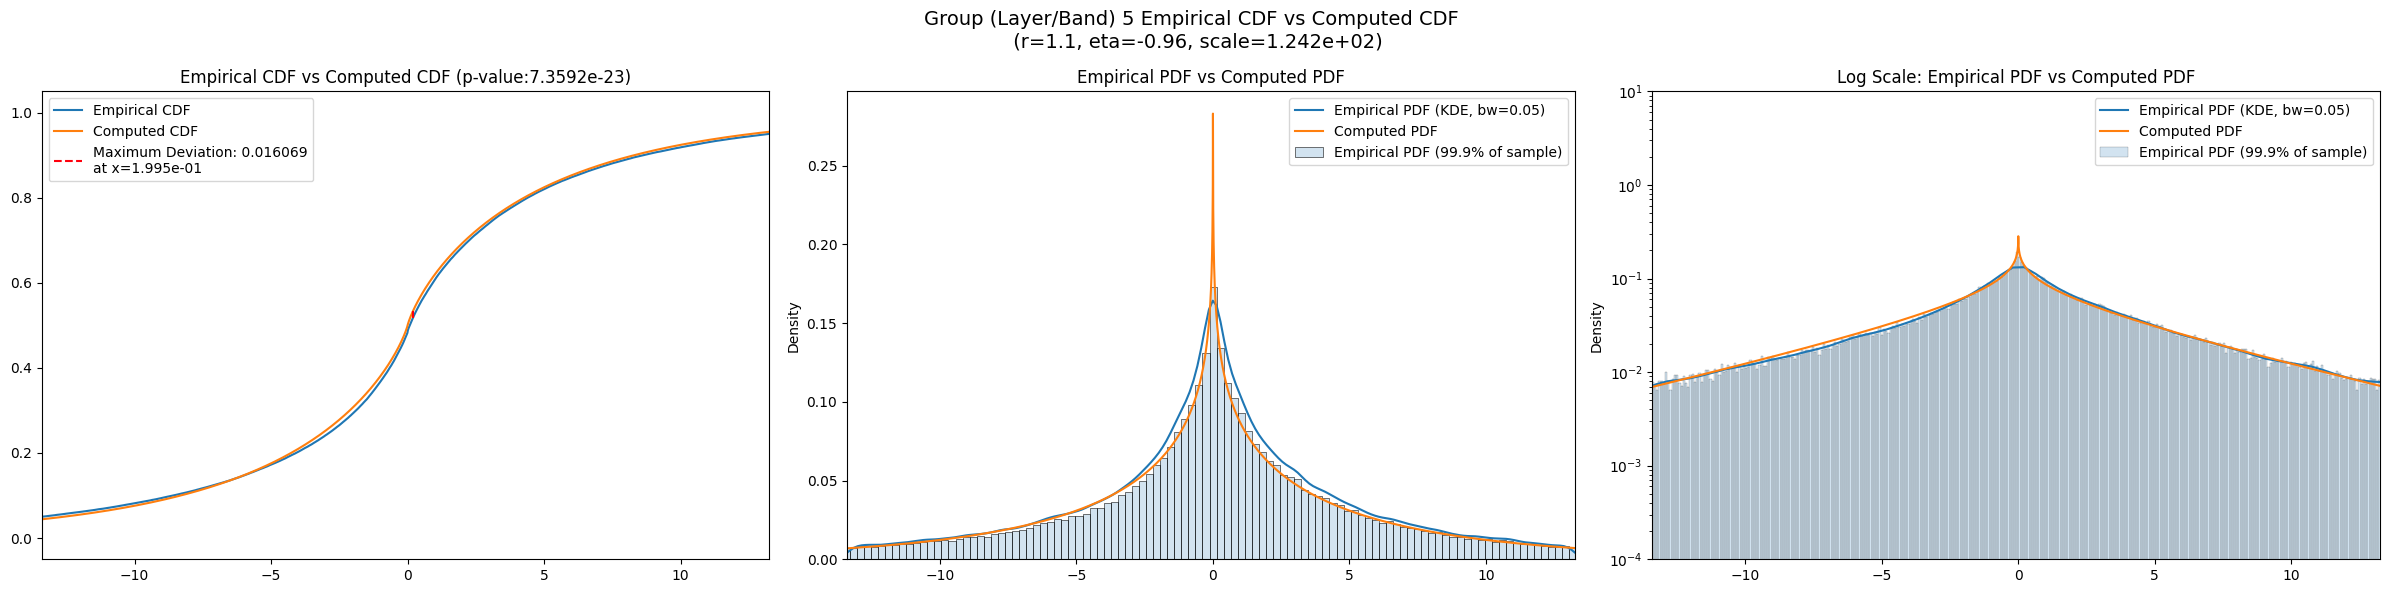

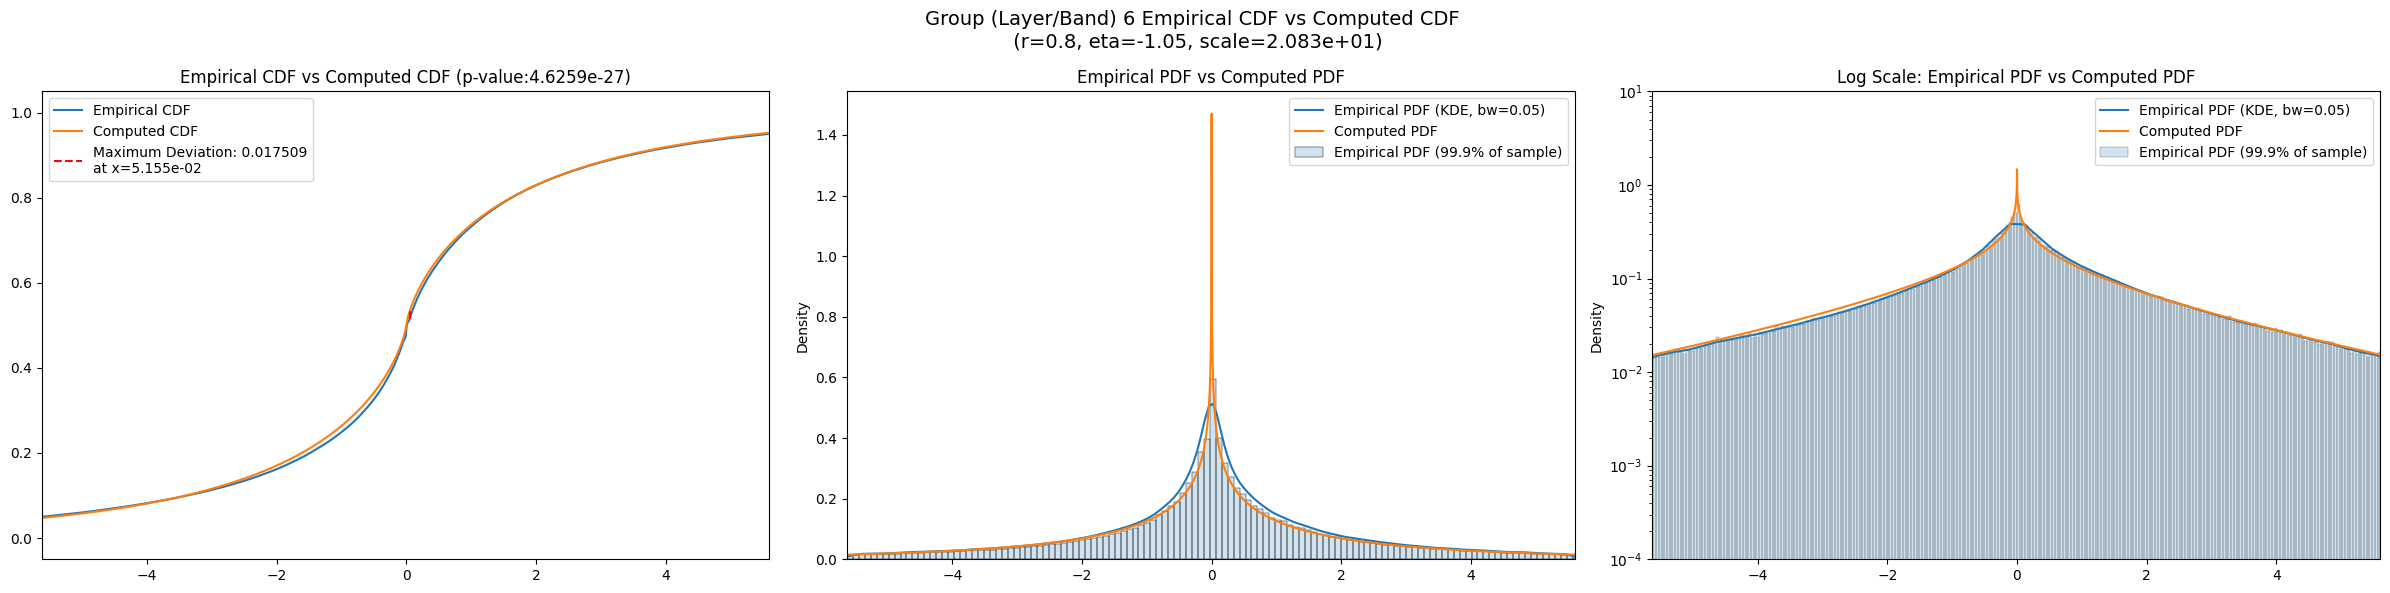

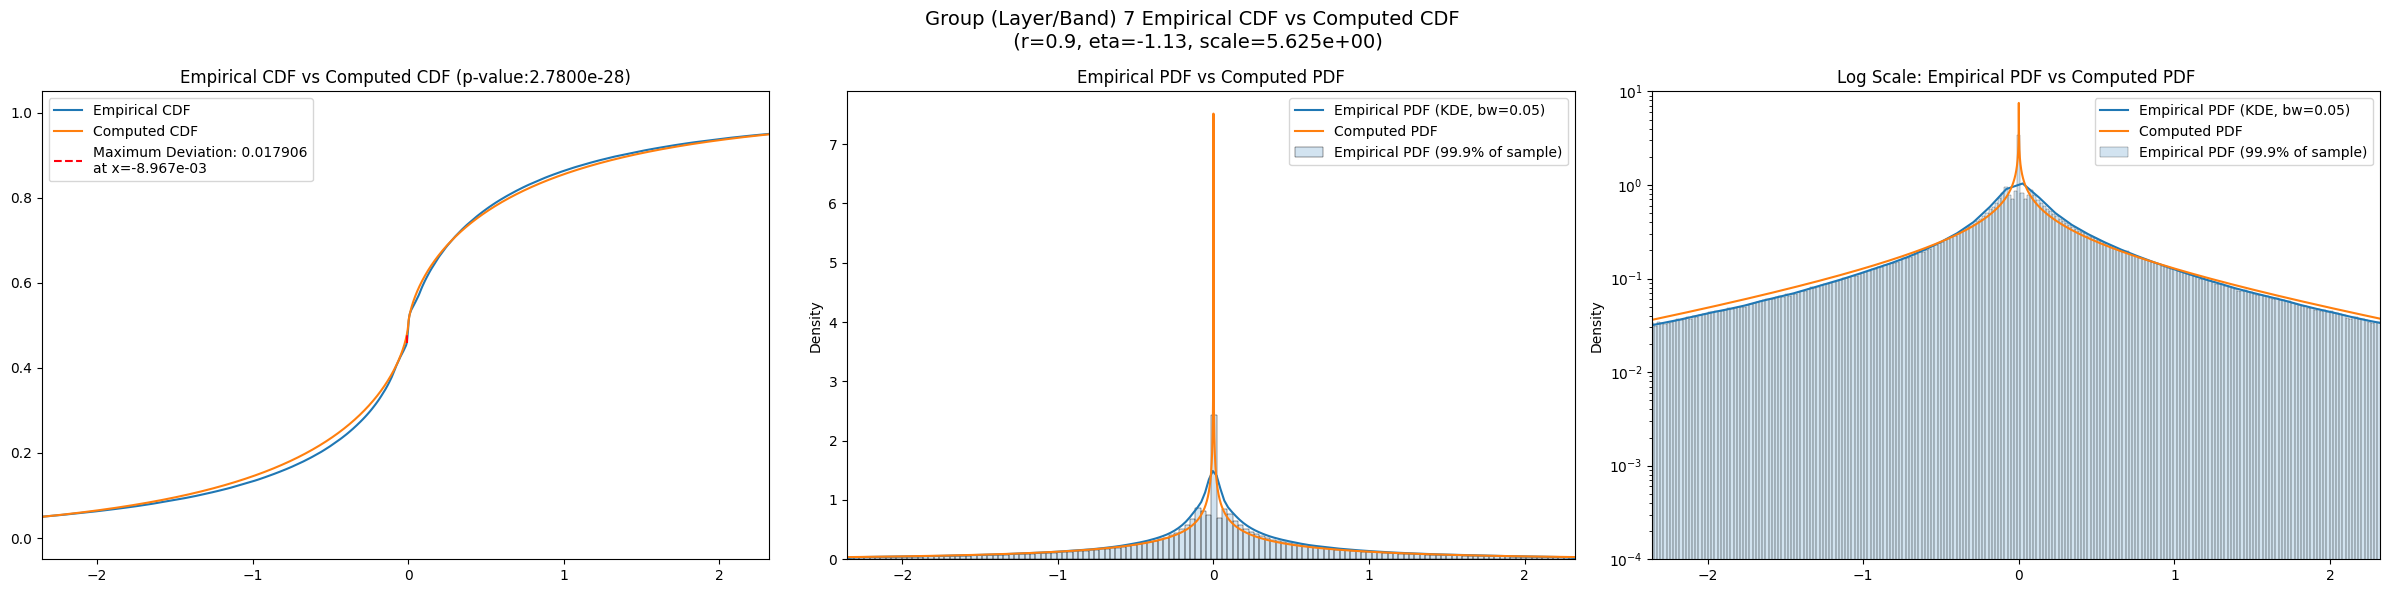

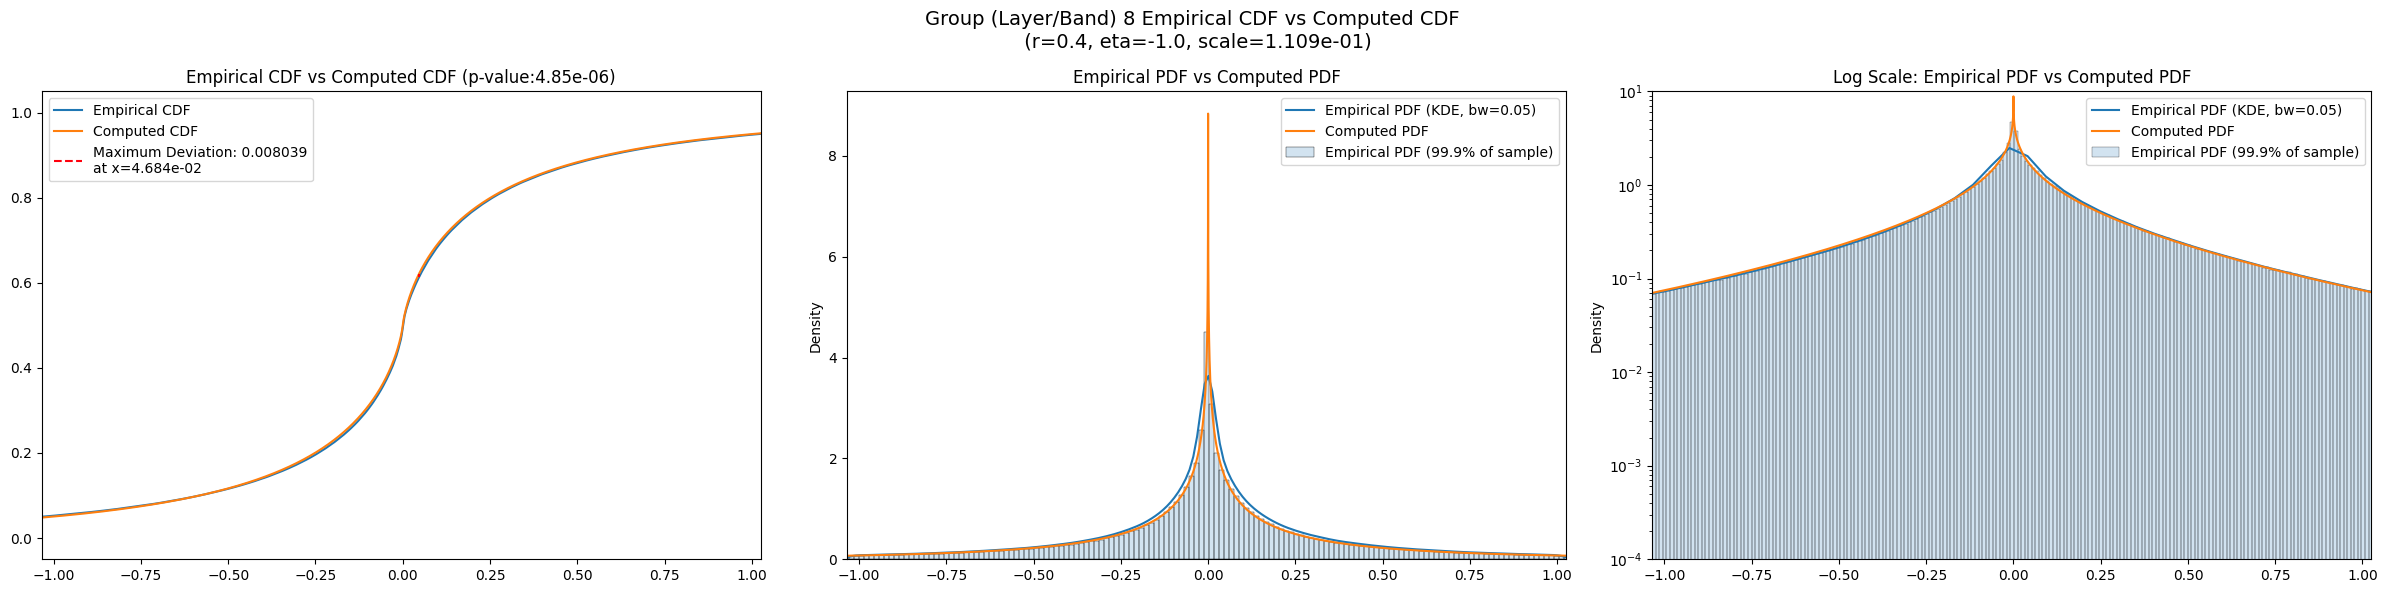

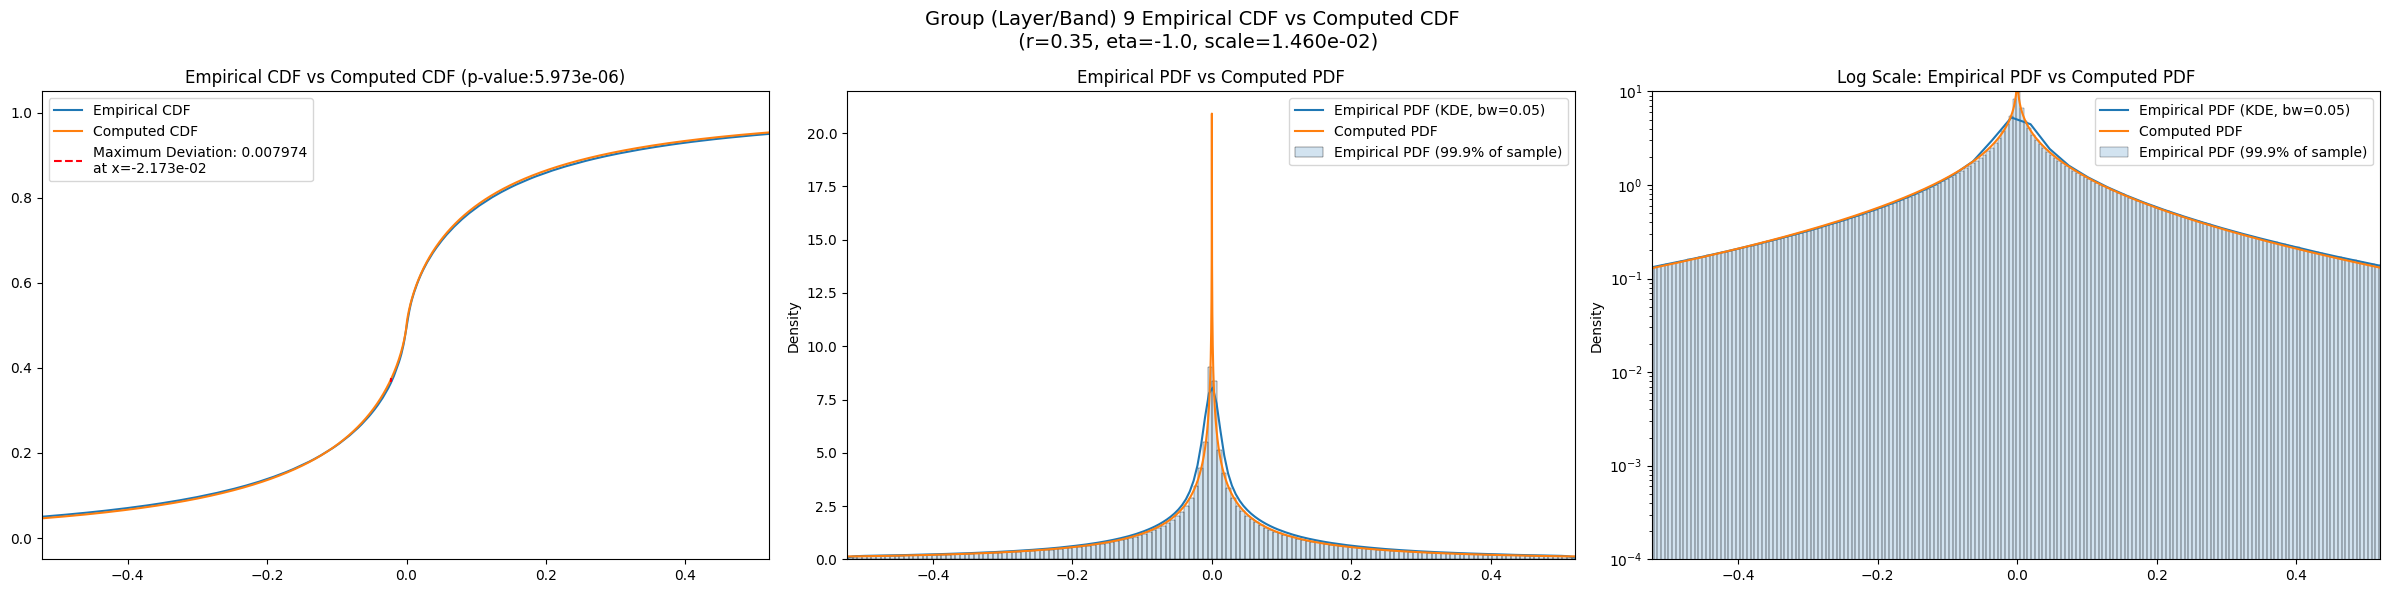

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      7638.174300  7124.338000  8164.031200  -0.282708   -0.434939   
3      1626.871300  1559.126000  1696.707300   0.652731    0.513061   
4       341.027560   323.160430   359.463470   2.263896    1.864998   
5        65.812890    61.691994    70.081420   4.177919    3.517911   
6        12.935615    11.939695    14.019106   7.678164    5.766460   
7         2.520173     2.289406     2.793002  12.723302    8.106244   
8         0.541199     0.483270     0.626779  22.243805   10.200109   
9         0.143161     0.127398     0.167005  24.571327   11.068905   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       -0.114432           2446             0.040339       20.0         20.0   
3        0.798774           9784             0.026761        9.9         -0.5   
4        2.751698          39136             0.017806       15.0         -0.9   
5        4.988661         156544             0.016196        0.8         -0.9   
6       12.299148         626176             0.018020        0.6         -1.0   
7       33.117836        2504704             0.018974        0.7         -1.1   
8       93.252760       10018816             0.008039        0.4         -1.0   
9       97.773170       40075264             0.010606        0.5         -1.1   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       91.731100              0.034148          6.506340e-03   
3      ...       34.385400              0.035974          1.949100e-11   
4      ...       13.697200              0.044220          6.160200e-67   
5      ...        5.077710              0.058002          0.000000e+00   
6      ...        1.866100              0.068588          0.000000e+00   
7      ...        0.722363              0.071974          0.000000e+00   
8      ...        0.309204              0.072987          0.000000e+00   
9      ...        0.146131              0.077864          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          84.094900             0.050255         8.282520e-06  69.265700   
3          34.733100             0.026610         1.883440e-06  27.442500   
4          11.816900             0.022387         1.801160e-17   9.956710   
5           4.390950             0.031197        8.390570e-133   3.564010   
6           1.601990             0.042593         0.000000e+00   1.281290   
7           0.622537             0.045808         0.000000e+00   0.492594   
8           0.265816             0.047348         0.000000e+00   0.208644   
9           0.124729             0.053132         0.000000e+00   0.097362   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.046707   4.476210e-05          6.780150e-04  
3           0.028779   1.789910e-07          1.608349e-06  
4           0.027909   6.461040e-27          3.297166e-11  
5           0.036110  8.762180e-178          1.528420e-35  
6           0.046102   0.000000e+00         3.468665e-167  
7           0.048161   0.000000e+00          0.000000e+00  
8           0.049484   0.000000e+00          0.000000e+00  
9           0.054926   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.040339                 0.027391          0.040339   
3                 0.026761                 0.013713          0.026761   
4                 0.017806                 0.006861          0.017806   
5                 0.016196                 0.003431          0.016069   
6                 0.018020                 0.001716          0.017509   
7                 0.018974                 0.000858          0.017909   
8                 0.008039                 0.000429          0.008039   
9                 0.010606                 0.000215          0.007974   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.034148             0.050255       0.046707  
3                  0.035974             0.026610       0.028779  
4                  0.044220             0.022387       0.027909  
5                  0.058002             0.031197       0.036110  
6                  0.068588             0.042593       0.046102  
7                  0.071974             0.045808       0.048161  
8                  0.072987             0.047348       0.049484  
9                  0.077864             0.053132       0.054926

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta   best_scale  \
layer                                                                        
2             7638.174300          0.040339   20.00     20.00  7801.812320   
3             1626.871300          0.026761    9.90     -0.50  3371.850170   
4              341.027560          0.017806   15.00     -0.90   937.916198   
5               61.064606          0.016069    1.10     -0.96   124.209097   
6               12.311246          0.017509    0.80     -1.05    20.834967   
7                2.313668          0.017909    0.90     -1.13     5.625084   
8                0.541199          0.008039    0.40     -1.00     0.110908   
9                0.143161          0.007974    0.35     -1.00     0.014601   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                      0.0  
5                    150.0  
6                     50.0  
7                     75.0  
8                      0.0  
9                      0.0

In [21]:
eng.quit()